In [1]:
# Step 1: Install and Configure PySpark
!pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=97617e081e38823696dd3e96cef797274d9dc5a52c2089f2325af628fc653d12
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


In [2]:
# Initialize a Spark session
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("SpotifyClustering").getOrCreate()

# Verify the Spark session
spark


In [3]:
# Step 2: Load Dataset
df = spark.read.csv('/spotify dataset.csv', header=True, inferSchema=True)
df.show(5)

+--------------------+--------------------+----------------+----------------+--------------------+--------------------+------------------------+-------------+--------------------+--------------+-----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+
|            track_id|          track_name|    track_artist|track_popularity|      track_album_id|    track_album_name|track_album_release_date|playlist_name|         playlist_id|playlist_genre|playlist_subgenre|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|
+--------------------+--------------------+----------------+----------------+--------------------+--------------------+------------------------+-------------+--------------------+--------------+-----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+
|6f807x0im

In [4]:
# Step 3: Preprocess Data (cast columns and handle nulls)
from pyspark.sql.functions import col

# Cast the required columns to float
df = df.withColumn("danceability", col("danceability").cast("float")) \
       .withColumn("energy", col("energy").cast("float")) \
       .withColumn("loudness", col("loudness").cast("float")) \
       .withColumn("valence", col("valence").cast("float")) \
       .withColumn("tempo", col("tempo").cast("float"))

# Verify the schema to ensure the columns are cast correctly
df.printSchema()


root
 |-- track_id: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_artist: string (nullable = true)
 |-- track_popularity: integer (nullable = true)
 |-- track_album_id: string (nullable = true)
 |-- track_album_name: string (nullable = true)
 |-- track_album_release_date: string (nullable = true)
 |-- playlist_name: string (nullable = true)
 |-- playlist_id: string (nullable = true)
 |-- playlist_genre: string (nullable = true)
 |-- playlist_subgenre: string (nullable = true)
 |-- danceability: float (nullable = true)
 |-- energy: float (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: float (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: float (nullable = true)
 |-- tempo: float (nullable = true)
 |-- duration_ms: double (nullable = true)



In [7]:
# Step 4: VectorAssembler for Features
from pyspark.ml.feature import VectorAssembler

# Define the features columns to be assembled
# Replace with your desired feature columns from the DataFrame
features = ['danceability', 'energy', 'loudness', 'valence', 'tempo']

# Assemble the features into a single vector column
assembler = VectorAssembler(inputCols=features, outputCol='features')
assembled_df = assembler.transform(df)

# Show the results
assembled_df.select('features').show(5)

+--------------------+
|            features|
+--------------------+
|[0.74800002574920...|
|[0.72600001096725...|
|[0.67500001192092...|
|[0.71799999475479...|
|[0.64999997615814...|
+--------------------+
only showing top 5 rows



In [8]:
# Remove rows with null values in the selected columns
df_clean = df.dropna(subset=features)

# Proceed with the VectorAssembler
assembler = VectorAssembler(inputCols=features, outputCol='features')
assembled_df = assembler.transform(df_clean)


In [9]:
from pyspark.ml.feature import VectorAssembler

# Set handleInvalid to 'skip' to ignore rows with null values
assembler = VectorAssembler(inputCols=features, outputCol='features', handleInvalid='skip')
assembled_df = assembler.transform(df)

# Proceed with the KMeans model
from pyspark.ml.clustering import KMeans
kmeans = KMeans(k=5, seed=1)  # Assuming 5 clusters
model = kmeans.fit(assembled_df)

# Make predictions
predictions = model.transform(assembled_df)
predictions.show(5)


+--------------------+--------------------+----------------+----------------+--------------------+--------------------+------------------------+-------------+--------------------+--------------+-----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+--------------------+----------+
|            track_id|          track_name|    track_artist|track_popularity|      track_album_id|    track_album_name|track_album_release_date|playlist_name|         playlist_id|playlist_genre|playlist_subgenre|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|            features|prediction|
+--------------------+--------------------+----------------+----------------+--------------------+--------------------+------------------------+-------------+--------------------+--------------+-----------------+------------+------+---+--------+----+-----------+------------+-

In [10]:
# Step 5: KMeans Clustering
from pyspark.ml.evaluation import ClusteringEvaluator

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette with squared euclidean distance = {silhouette}")


Silhouette with squared euclidean distance = 0.6967775462321066


In [11]:
# Show the cluster centers
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)


Cluster Centers: 
[ 0.62640349  0.60095969 -7.66511222  0.50922444 83.37024782]
[  0.6726747    0.74272264  -6.40089288   0.47961275 124.45145554]
[  0.56418322   0.70415614  -6.47464656   0.54527556 175.00150076]
[  0.61921577   0.69514067  -6.77198221   0.48880789 144.74776343]
[  0.70195254   0.68952582  -6.71540769   0.55439461 101.16103458]


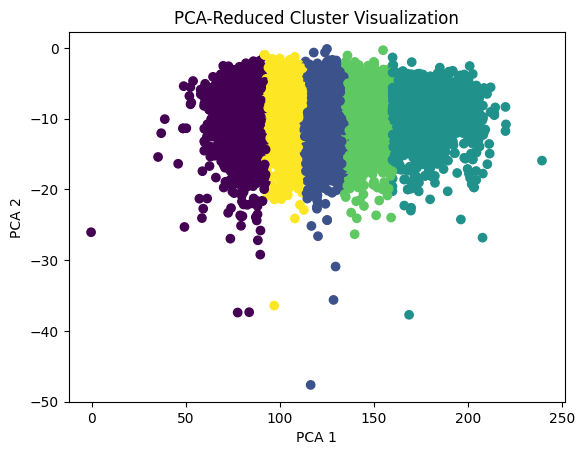

In [12]:
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Perform PCA to reduce to 2 dimensions for visualization
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(assembled_df)
pca_result = pca_model.transform(assembled_df)

# Convert PCA results to Pandas for plotting
pca_df = pca_result.select("pca_features").toPandas()
pca_values = pca_df['pca_features'].apply(pd.Series)

# Add predictions to the PCA data
pca_values['cluster'] = predictions.select('prediction').toPandas()

# Plotting the PCA-reduced clusters
plt.scatter(pca_values[0], pca_values[1], c=pca_values['cluster'])
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA-Reduced Cluster Visualization')
plt.show()


In [13]:
# Step 6:Save the clustered results
predictions.select('track_name', 'prediction').write.csv('/content/clustered_spotify_songs.csv')


In [14]:
!pip install pyspark pandas


In [17]:
# Import necessary libraries
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Upload the dataset
from google.colab import files
uploaded = files.upload()

# Load the dataset
file_path = list(uploaded.keys())[0]
data = pd.read_csv(file_path)

# Display first few rows of the dataset to understand its structure
data.head()

# Preprocess Data for ALS (Collaborative Filtering):
# Simulate 'userId', 'trackId', and use 'track_popularity' as 'rating'
data['userId'] = pd.factorize(data['playlist_id'])[0]
data['trackId'] = pd.factorize(data['track_id'])[0]
data['rating'] = data['track_popularity']  # Use track popularity as a proxy for rating

# Start Spark session
spark = SparkSession.builder.master("local").appName("SpotifyRecommendation").getOrCreate()

# Convert to Spark DataFrame for ALS
data_spark = spark.createDataFrame(data[['userId', 'trackId', 'rating']])

# Build the ALS model (Collaborative Filtering)
als = ALS(maxIter=10, regParam=0.1, userCol="userId", itemCol="trackId", ratingCol="rating", coldStartStrategy="drop")
model = als.fit(data_spark)

# Function for ALS recommendations (user-based)
def get_als_recommendations():
    # Generate top 10 recommendations for all users
    user_recommendations = model.recommendForAllUsers(10)
    user_recommendations.show()

    # Evaluate the model
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
    predictions = model.transform(data_spark)
    rmse = evaluator.evaluate(predictions)
    print(f"Root Mean Squared Error (RMSE): {rmse}")

# Preprocess Data for Content-Based Filtering (Song-Based)
# We'll use 'tempo', 'loudness', 'valence', 'danceability', 'energy', 'acousticness'
features = ['tempo', 'loudness', 'valence', 'danceability', 'energy', 'acousticness']

# Drop rows with missing values for these features
data_cleaned = data.dropna(subset=features)

# Normalize the features for similarity calculation
scaler = MinMaxScaler()
data_cleaned[features] = scaler.fit_transform(data_cleaned[features])

# Function for content-based recommendations (song-based)
def get_song_recommendations(track_name, num_recommendations=10):
    # Find the song in the dataset
    song_data = data_cleaned[data_cleaned['track_name'].str.lower() == track_name.lower()]

    if song_data.empty:
        return "Song not found in the dataset."

    # Get the index of the selected song
    song_index = song_data.index[0]

    # Compute cosine similarity between the selected song and all other songs
    cosine_sim = cosine_similarity([data_cleaned.loc[song_index, features]], data_cleaned[features])

    # Get the top N most similar songs (excluding the song itself)
    similar_songs = cosine_sim.argsort()[0][-num_recommendations-1:-1][::-1]

    # Return the top similar songs
    return data_cleaned.iloc[similar_songs][['track_name', 'track_artist', 'playlist_genre', 'track_popularity']]

# Main Function to choose between ALS and Content-Based Filtering
def main():
    print("Welcome to the Spotify Recommendation System!")
    print("1. User-based recommendation (Collaborative Filtering using ALS)")
    print("2. Song-based recommendation (Content-based Filtering using cosine similarity)")

    choice = input("Enter 1 or 2 to choose the recommendation system: ")

    if choice == '1':
        print("You chose User-based recommendation system.")
        get_als_recommendations()

    elif choice == '2':
        track_name = input("Enter the name of the song you want recommendations for: ")
        recommended_songs = get_song_recommendations(track_name, num_recommendations=10)

        if isinstance(recommended_songs, str):
            print(recommended_songs)
        else:
            print("Recommended songs based on", track_name)
            print(recommended_songs)
    else:
        print("Invalid choice. Please enter 1 or 2.")




Saving spotify dataset.csv to spotify dataset (2).csv
Welcome to the Spotify Recommendation System!
1. User-based recommendation (Collaborative Filtering using ALS)
2. Song-based recommendation (Content-based Filtering using cosine similarity)
Enter 1 or 2 to choose the recommendation system: 2
Enter the name of the song you want recommendations for: Shape of you
Recommended songs based on Shape of you
               track_name                  track_artist playlist_genre  \
17488        Shape of You                    Ed Sheeran          latin   
23867        Shape of You                    Ed Sheeran            r&b   
23899        Shape of You                    Ed Sheeran            r&b   
1218         Shape of You                    Ed Sheeran            pop   
2317         Shape of You                    Ed Sheeran            pop   
2838         Shape of You                    Ed Sheeran            pop   
8533   Surrounded By Hoes                       50 Cent            rap   
20

In [18]:
# Run the main function
main()

Welcome to the Spotify Recommendation System!
1. User-based recommendation (Collaborative Filtering using ALS)
2. Song-based recommendation (Content-based Filtering using cosine similarity)
Enter 1 or 2 to choose the recommendation system: 1
You chose User-based recommendation system.
+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|     0|[{41, 87.915306},...|
|     1|[{335, 98.24785},...|
|     2|[{179, 90.07329},...|
|     3|[{8444, 93.529335...|
|     4|[{8444, 89.21824}...|
|     5|[{344, 94.87983},...|
|     6|[{139, 75.29366},...|
|     7|[{716, 96.83272},...|
|     8|[{157, 86.21298},...|
|     9|[{179, 96.21013},...|
|    10|[{100, 97.97541},...|
|    11|[{1326, 103.22472...|
|    12|[{784, 78.96906},...|
|    13|[{19550, 61.30101...|
|    14|[{16753, 92.52226...|
|    15|[{10462, 76.80018...|
|    16|[{1123, 79.63404}...|
|    17|[{1308, 99.69892}...|
|    18|[{2873, 98.24344}...|
|    19|[{1289, 81.99814}...|
+------+----------------